In [1]:
#import packages

import numpy as np
import pandas as pd

import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
### Gather
#create listings dataframe from 'listings.csv'

listings_raw = pd.read_csv('listings.csv', index_col = 'id')

listings = listings_raw.copy()

First we want to take a brief look at the data and check the data type of each column

In [3]:
###assess
#take a brief look at the data
listings.head()

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",I have one roommate who lives on the lower lev...,...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [4]:
###assess
#Check the info of the dataframe. Identify the datatype of each column
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 12147973 to 14504422
Data columns (total 94 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   listing_url                       3585 non-null   object 
 1   scrape_id                         3585 non-null   int64  
 2   last_scraped                      3585 non-null   object 
 3   name                              3585 non-null   object 
 4   summary                           3442 non-null   object 
 5   space                             2528 non-null   object 
 6   description                       3585 non-null   object 
 7   experiences_offered               3585 non-null   object 
 8   neighborhood_overview             2170 non-null   object 
 9   notes                             1610 non-null   object 
 10  transit                           2295 non-null   object 
 11  access                            2096 non-null   object 


### Q1
The first question we are trying to answer is whether we can build a model to predict the listing from the variables provided in this dataframe.
There will be several steps to take in order to answer this question:
    1. Perfrom data cleaning which includes drop unrelated columns, drop empty columns, fill or drop null values, and converting the data to proper data type for buidling the model
    2. Choose a proper listing price range for building the model
    3. Select numerical columns as X, listing price as Y, build the model, test how the model performs
    4. Include categroical columns, build dummy columns, rebuild model and test to see if the model improves

<AxesSubplot:>

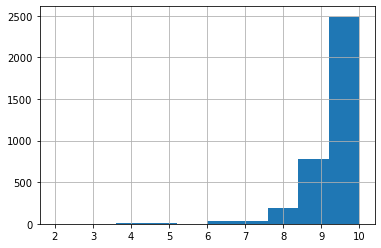

In [17]:
listings['review_scores_accuracy'].hist()

In [8]:
### Clean
# 1. Data cleaning
# Clean the dataset to remove irrelavent columns and fill or remove empty values.

def clean_dataset():
    # drop columns that is not related to this study; Values such as urls, host names are 
    # 'unique indentifiers' that are not relavent to listing prices and needs to be dropped.
    # Some columns such as State, country and country code that are indentical for all the listings in 
    # Boston needs to be dropped. Some columns are dupicated to other column such as zipcode which has the
    # same purpose as neighbourhood.
    cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 
                    'thumbnail_url', 'medium_url', 'picture_url', 
                    'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_thumbnail_url', 
                    'host_picture_url', 'state', 'zipcode', 'market', 
                     'country_code', 'country', 'jurisdiction_names', 'smart_location']
    listings.drop(cols_to_drop, axis = 1, inplace = True)

    
    # drop columns with more than 35% null values; here we define the threshold as 35%.
    listings.dropna(axis = 1, thresh = len(listings)*0.35, inplace = True)
    
    # these numerical values have '$' and  before the numbers and acutally shows as object dtype in the data frame
    # remove '$' and convert the datatype from object to float
    
    for price_list in ['price', 'cleaning_fee', 'security_deposit', 'extra_people']:
        
        listings[price_list] = listings[price_list].map(lambda p : p.replace('$','').replace(',',''), na_action = 'ignore')
        
        listings[price_list] = listings[price_list].astype(float)
        
        listings[price_list].fillna(listings[price_list].median(), inplace = True)
    
    # drop missing values in bathrooms, bedrooms and beds; The beds, bathrooms and bedrooms values are
    # within a relatively small range (0 to 16 for beds), it might be OK to fill null with median beds numbers.
    # But because the number of null values in these 3 columns is very small
    # (around 9), it is much easier to drop these rows without any significant impacts.
    listings.dropna(axis = 0, subset = ['bathrooms', 'bedrooms', 'beds'], inplace = True)
    
        
    # fill the review socres with the mean values; because these columns have a relativey large numcer of null values
    # we can't simply drop the rows. Since the dataframe is not sorted in a specific order, and the review scores 
    # shows a relatively narrow distribution (mostly concentrated at 90-100, or 9 to 10) base on the histogram
    # So here we fill null with mean value.
    
    #code to check the 
    #listings['review_scores_x'].hist(); #replace 'x' with a specific word
    for review in ["review_scores_rating", "review_scores_accuracy", "review_scores_location"]:
        listings[review].fillna(listings[review].mean(), inplace= True)

# run the function
clean_dataset()

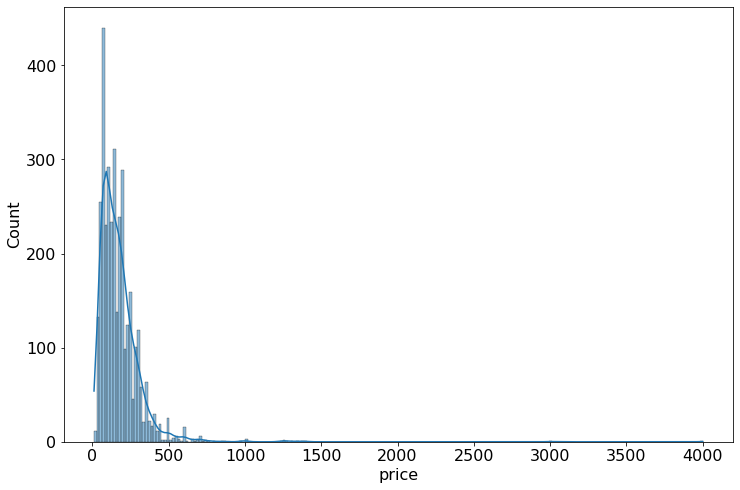

In [9]:
### clean
# plot the price distribution of all the listings in Boston

matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize = (12,8))
sns.histplot(listings['price'], kde=True, fill = True)
plt.show()

#the plots shows that the price ranged from 0 to 4000, however, there are very few listings <20 or >500. 


In [10]:
### clean
#therefore, here we filter out the outliers and only keep the entries with price ranged from 20 to 500.
#creat a new_listing variable
new_listings = listings[(listings['price']>20) & (listings['price']<500)].copy()

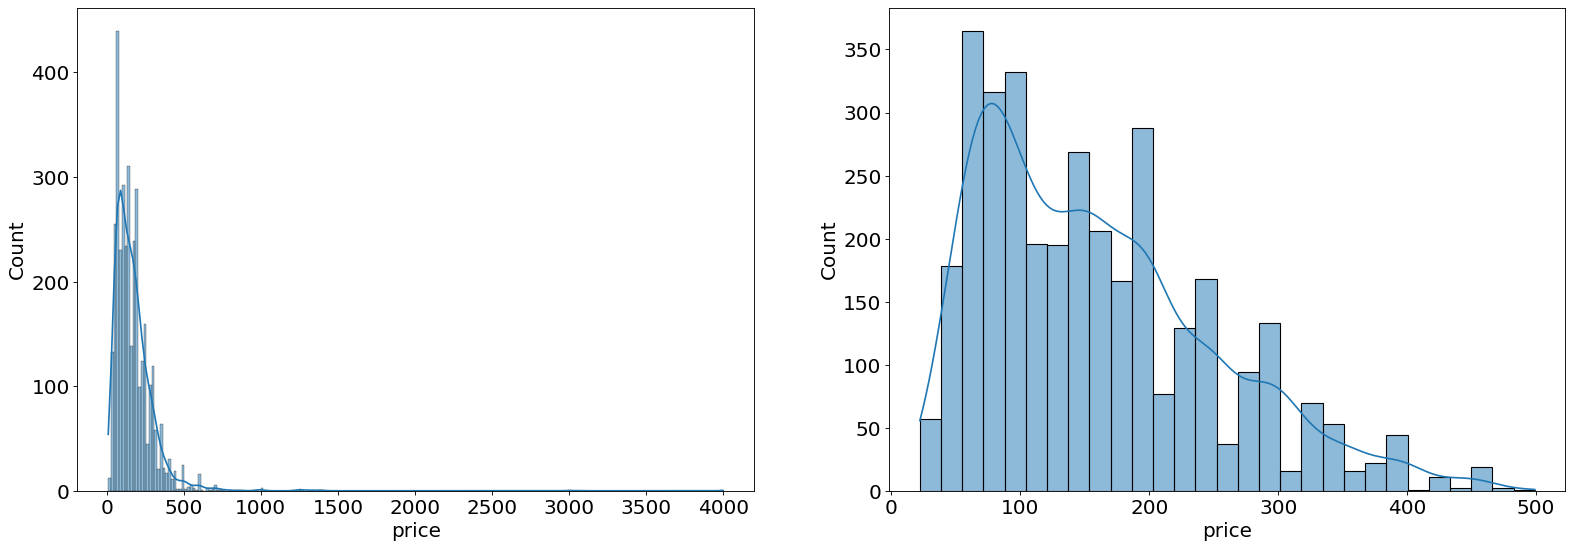

In [11]:
### clean
# compare the histrogram of these two dataframes side by side to visualize this change

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=80)

sns.histplot(listings['price'], kde=True, fill = True, ax=axs[0])

sns.histplot(new_listings['price'], kde=True, fill = True, ax = axs[1])
plt.show()

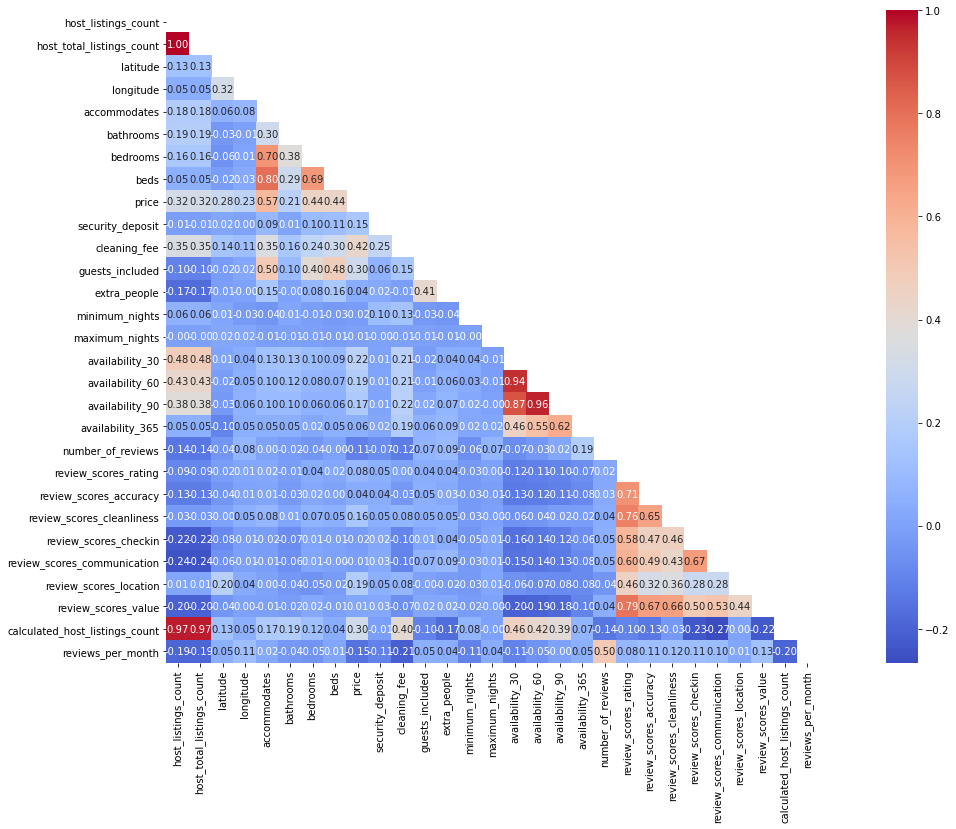

In [12]:
# find out the correlation values between all the numericl values
matplotlib.rcParams.update({'font.size': 10})
corr = new_listings.select_dtypes(include = ['int64','float64']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,12))
sns.heatmap(corr, mask = mask, square = True, annot = True, fmt = '.2f', cmap ='coolwarm')
plt.show()


In [13]:
### Model
#create linear regression model using only the numerical values

#assign X and y values; 'price' is the variable that we are trying to predict
X = new_listings[['beds','cleaning_fee','security_deposit', 'guests_included','review_scores_rating','minimum_nights',
                 'maximum_nights', 'number_of_reviews','extra_people']]
y = new_listings['price']

#perfrom train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=44)

#creat and fit model
lm_model = LinearRegression(normalize = True)
lm_model.fit(X_train, y_train)

#check the R^2 score of the predict value comparing to 
y_test_preds = lm_model.predict(X_test)
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)


"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for your model was 0.33991076152643696 on 1039 values.'

The r-squared score is 0.34, which means the model can't predict the listing price well
We might want to include categorical values to see if we can improve the model

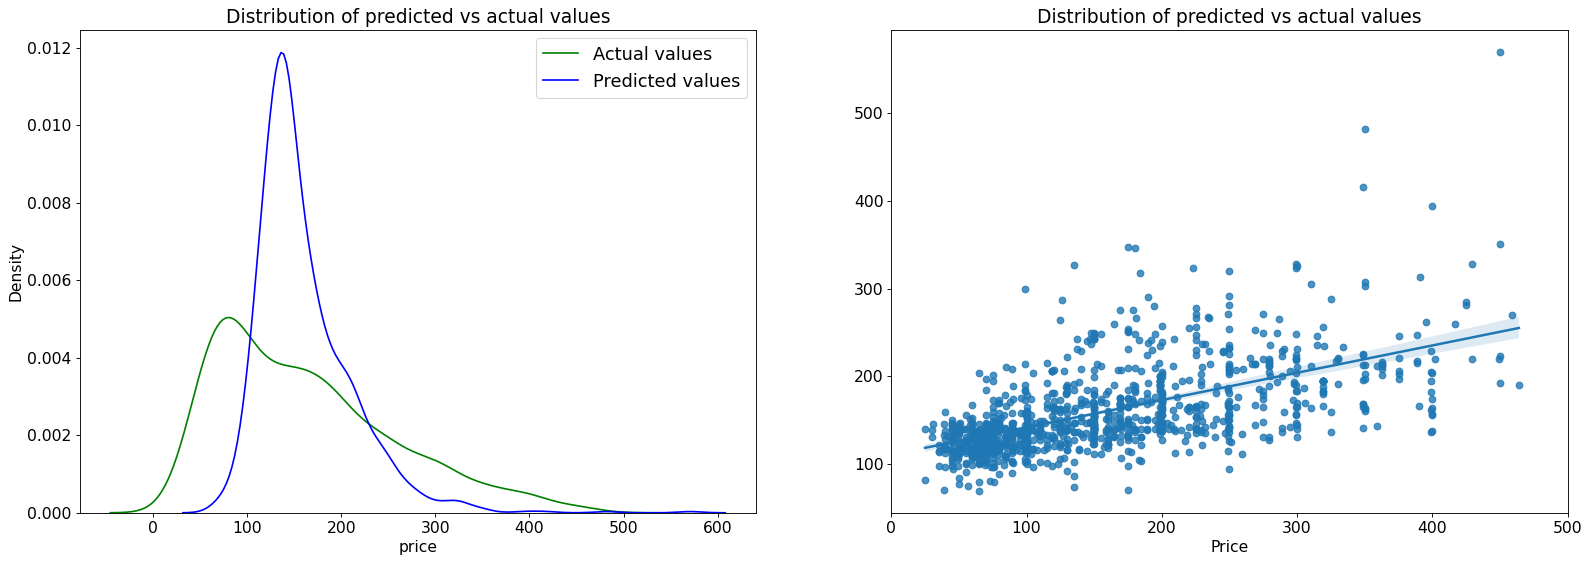

In [11]:
### Visualize ###

matplotlib.rcParams.update({'font.size': 14})

#plot the predicted value vs. actual value
fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=80)
axs[0].set_title('Distribution of predicted vs actual values')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values', ax=axs[0])
ax2 = sns.kdeplot(data=y_test_preds, color="b", label='Predicted values', ax=ax1)
axs[0].legend(['Actual values','Predicted values'],fontsize = 16)
    
sns.regplot(x=y_test, y=y_test_preds)
plt.title('Distribution of predicted vs actual values')
plt.xlabel('Price')
plt.xlim(0,500)
plt.show()
plt.close()

The plot on the left shows the actual and predicted price distributions; apparently the predicted value shows a much narrow distribution comparing to the actual value. 

The plot on the right shows a regression plot comparing the predicted value to actual value.If it perfectly predicted, the dots should be aline on the linear regression line. Apparently, the predicted value is relatively far off from the actual values.

In [12]:
### Cleaning


# the function to create dummy columns from categorical columns
# dummy varible is a commonly used method to covert categorical input varialble into numerical variable.
# It is most useful when there are a few categories, for example the cancellation policy has "strict", "moderate",
# and "flexible" 3 levels, and it can be easily converty into 3 numercial dummy columns.
# But for variables with too much levels like 500, it will create too many new variable and make the modeling 
# time consuming, and we need to see other method for such variables.

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col,axis=1), pd.get_dummies(df[col], prefix = col, prefix_sep = '_', drop_first = True, dummy_na = dummy_na)], axis = 1)
        except:
            continue
    return df
                

In [13]:
### Cleaning

# create a new listing with categorical columns that are suitable to convert into numercial dummy columns

df2 = new_listings[['beds','cleaning_fee','security_deposit', 'guests_included', 'neighbourhood_cleansed', 'city', 'property_type',
                   'room_type', 'bed_type', 'requires_license', 'instant_bookable', 'cancellation_policy', 
                    'require_guest_phone_verification', 'require_guest_profile_picture','price' ]].copy()

In [14]:
# select all the categorical columns in df2
cat_cols = list(df2.select_dtypes(include=['object']).copy().columns)

In [15]:
### Model


def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    
    # Drop the rows with missing response values
    
    df = df.dropna(subset= [response_col], axis = 0)
    
    # Drop columns with NaN for all the values
    
    df = df.dropna (how = 'all', axis = 1)
    
    # Create_dummy_df to dummy categorical columns
    
    df = create_dummy_df(df, cat_cols, dummy_na)
    
    #Fill the mean of the column for any missing values 
    
    fill_mean = lambda col:col.fillna(col.mean())
    df = df.apply(fill_mean, axis = 0)
    
    #Split into explanatory and response variables
    
    X = df.drop(columns = response_col)
    y = df[response_col]
    
    #Split into train and test
    
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=50)
       
    lm_model = LinearRegression(normalize=True) #Initiate
    lm_model.fit(X_train, y_train) #Fit
    
    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    #y_train_preds = lm_model.predict(X_train)
    
    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    #train_score = r2_score(y_train, y_train_preds)

    return test_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds


#Test your function with the above dataset
test_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds = clean_fit_linear_mod(df2, 'price', cat_cols, dummy_na=False)

#Print training and testing score
print("The rsquared on the test data was {}.".format(test_score))

The rsquared on the test data was 0.5921733020982662.


The R squared value is improved when categorical values are included. A possible reason is that the listing price is affected by room type (e.g. apartment, house) and neighbourhood (e.g. Downtown vs. suburb locations)

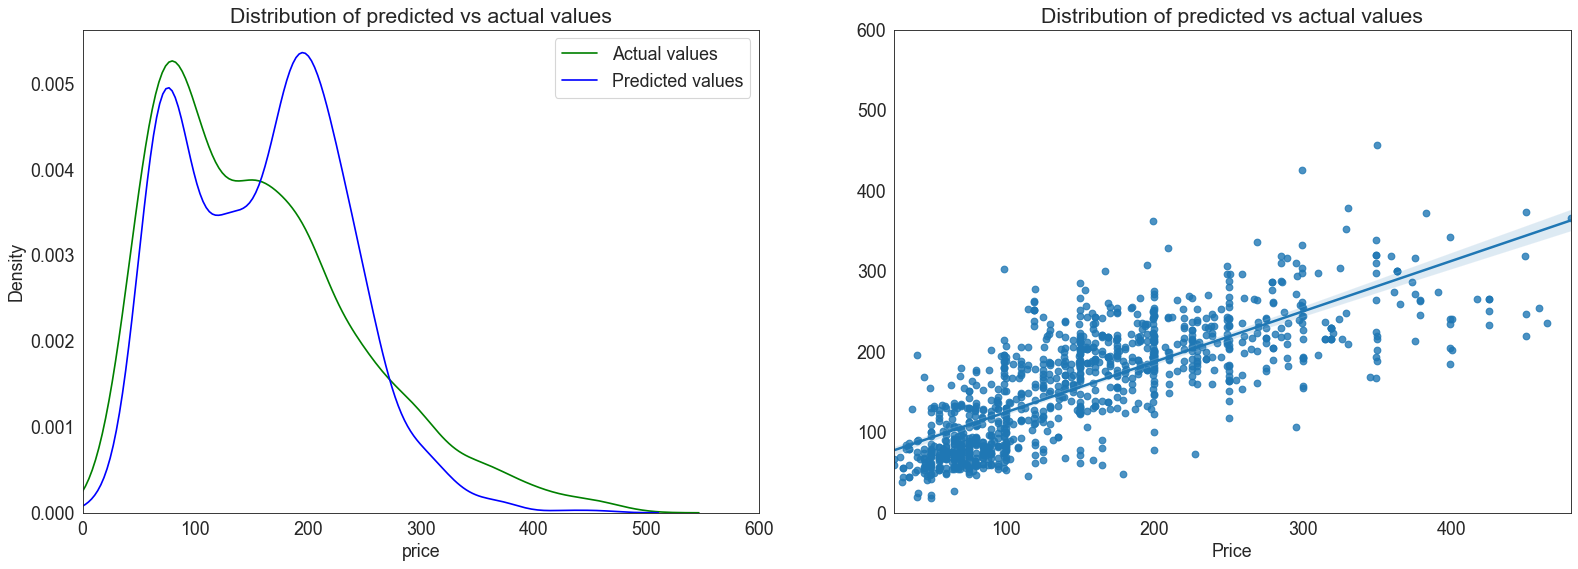

In [29]:
### Visualization

# compare the predicted price distribution value with actual price distribution
fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=80)
axs[0].set_title('Distribution of predicted vs actual values')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values', ax=axs[0])
ax2 = sns.kdeplot(data=y_test_preds, color="b", label='Predicted values', ax=ax1)
axs[0].legend(['Actual values','Predicted values'],fontsize = 16)
axs[0].set_xlim([0,600])

# compare the predicted price value with actual price value
sns.regplot(x=y_test, y=y_test_preds)
plt.title('Distribution of predicted vs actual values')
plt.xlabel('Price')
plt.ylim([0,600])
plt.show()
plt.close()

The plot on the left shows the actual and predicted price distributions; apparently the predicted value shows a similar distribution comparing to the actual value, but with an extra peak near $250, and is much improved comparing to the previous model.

The plot on the right shows a regression plot comparing the predicted value to actual value.If it perfectly predicted, the dots should be aline on the linear regression line. Apparently, the model is much improved from the previous model.

### Q1 Conclusion

We can build a reasonably good linear regression model to predict the lisiting price in Boston by including both numerical and categroical variables. Other models can be explored in future studies.

### Q2

Now we are trying to answer the second quesiton: How does geo-location affects the listing price?

We tackle this question by visualize and anlyze columns that are related to the locations such as "neibourhood". We also need to combine the result with an actual map of Boston to draw conconlusion.
(actual map show in the blog post)

In [30]:
###Assess

# the data set has a column named 'neighbourhood_cleansed' which contains cleaned neighbourhood names
# here we group the dataset by neighbourhood and see how each neighbourhood's median price looks like
# sort this value in an ascending order
nbhd = df2.groupby('neighbourhood_cleansed')['price'].median().sort_values()

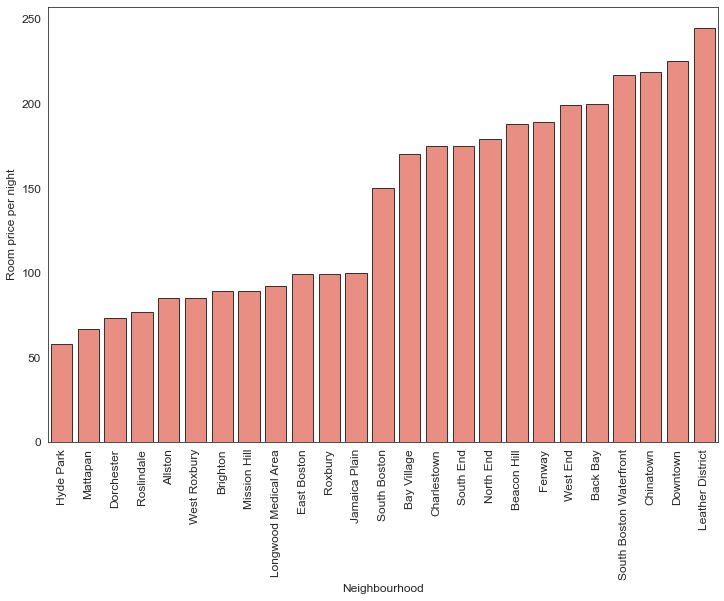

In [31]:
### Visualization

# visualize the listing price data of each neighourhood
plt.figure(figsize = (12,8))

sns.barplot(x= nbhd.index, y = nbhd, edgecolor ='.2', color = 'salmon')
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Neighbourhood', fontsize = 12)
plt.ylabel('Room price per night', fontsize = 12)
plt.show()

Apprently the neibouhood located close to city center have higher listing price comparing to those located in the suburbs. But bar plot have limited informaiton, so we need a better visulazation.

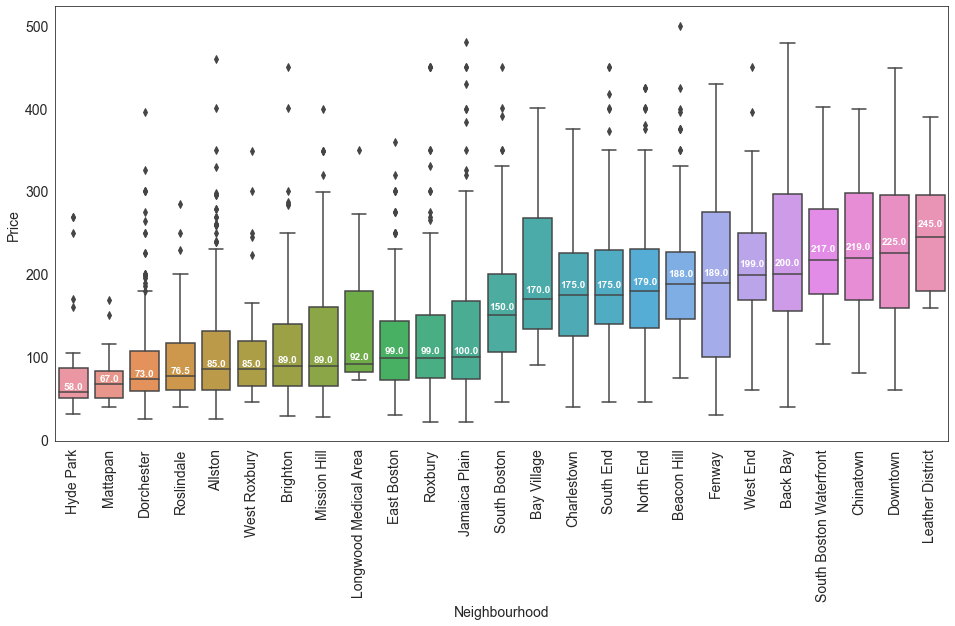

In [19]:
#Visualizaiton

# the bar plot contains limited information, there fore a box plot is used. 
# a box plot can show the range, median value and outliers of listing prices in each neighbourhood.
# script also included to print the median value for better visualization

sns.set_style("white")
plt.figure(figsize=(16,8))
box_plot = sns.boxplot(data=new_listings, x='neighbourhood_cleansed', y='price', order = nbhd.index)
plt.xlabel('Neighbourhood')
plt.ylabel('Price')
plt.xticks(rotation = 90)

nbhd_median = new_listings.groupby('neighbourhood_cleansed')['price'].median().sort_values()

vertical_offset = nbhd_median * 0.05

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, nbhd_median[xtick] + vertical_offset[xtick], nbhd_median[xtick], 
                  horizontalalignment='center',size='x-small',color='w',weight='semibold', fontsize =10)

plt.show()

It it clear that the neibourhood near city center or near tourist attractions have higher listing price comparing to suburb locations; But we also want find out how other factors affect the listing price

In [20]:
### Assess

#here we want to check how the property type affects the listing price

pptp = df2.groupby('property_type').mean()[df2.groupby('property_type').count()>20]['price'].sort_values()
pptp.dropna()



property_type
House              114.382463
Townhouse          123.000000
Bed & Breakfast    131.000000
Apartment          168.465456
Condominium        172.972973
Loft               177.131579
Name: price, dtype: float64

Seems Apartments, Loft and Condo has higher listing price comparing to House, Townhouse, and B&B. 
But before we jump to the conclusion that apartment is more expensive than house on Airbnb, Let's check each property type is distributed in each neibourhood.

In [32]:
### Assess
#here we want to check how many each property type each neighbourhood have
nbhd_pptp = df2.groupby(['neighbourhood_cleansed', 'property_type'])['property_type'].count()
nbhd_pptp

neighbourhood_cleansed  property_type
Allston                 Apartment        175
                        Condominium        8
                        House             69
                        Loft               1
                        Townhouse          1
                                        ... 
West End                Apartment         47
                        Condominium        2
West Roxbury            Apartment         15
                        House             29
                        Townhouse          2
Name: property_type, Length: 130, dtype: int64

It seems difficult to show the full list; Let's visualize a few typical neibourhood and check

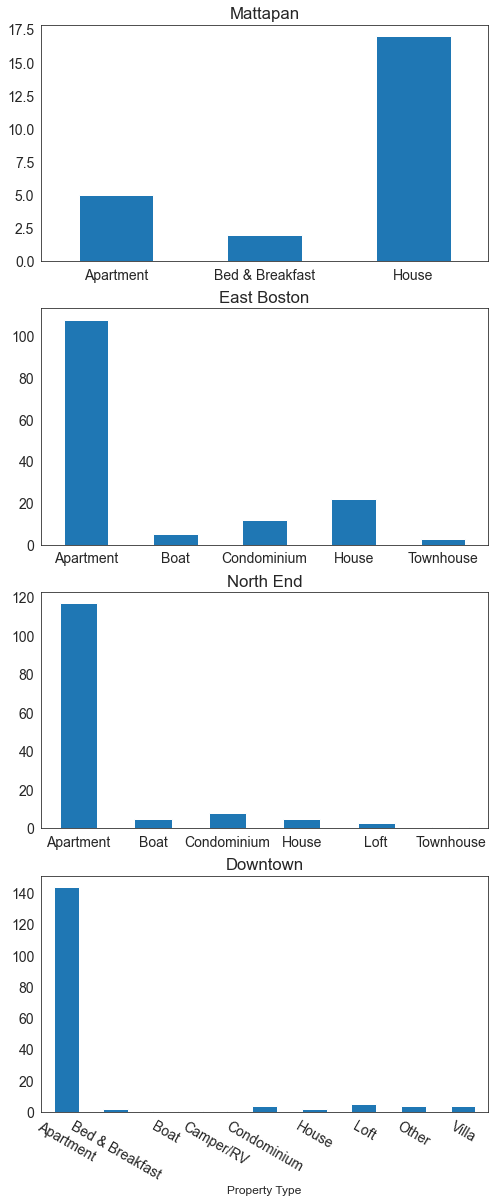

In [22]:
### Visualization

#visulized a few typical neighboorhood; as expected those locations near city center have more apartments
#while suburb locations have more house
f, a = plt.subplots(4,1, figsize = (8,20))
nbhd_pptp['Mattapan'].plot(kind='bar', ax = a[0])
a[0].set_xticklabels(nbhd_pptp['Mattapan'].index,rotation =0)
a[0].set_xlabel('')
a[0].set_title('Mattapan')

nbhd_pptp['East Boston'].plot(kind='bar', ax = a[1])
a[1].set_xticklabels(nbhd_pptp['East Boston'].index,rotation =0)
a[1].set_title('East Boston')
a[1].set_xlabel('')

nbhd_pptp['North End'].plot(kind='bar', ax = a[2])
a[2].set_xticklabels(nbhd_pptp['North End'].index,rotation =0)
a[2].set_title('North End')
a[2].set_xlabel('')

nbhd_pptp['Downtown'].plot(kind='bar', ax = a[3])
a[3].set_xticklabels(nbhd_pptp['Downtown'].index,rotation =-30)
a[3].set_title('Downtown')
a[3].set_xlabel('Property Type', fontsize = 12)



plt.show()

Apparently new downtown locations have more apartments, while suburb locations have more house;

### Q2 Conclusion

The listing price is affected by the geo-location of the listing. The listings in near downtown locations have higher price and contains more apartments, while the listings in suburb locations have relatively lower price and contains more houses.

### Q3

Does the price of the Airbnb listings in Boston has any seaonality?

We plan to solve this question by looking into the calendar dataset. Specifically, we plan to check the median price of each month and the supply of each month. Combining such information with special characteristics of Boston, we can draw a clear picture on how the listing price in Boston varies with time.

In [19]:
### Gather
# load the calendar data file
calendar_raw = pd.read_csv('calendar.csv')

calendar = calendar_raw.copy()

In [20]:
### Assess
# check the dataframe info
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [21]:
### Clean
# clean dataframe

# drop missing values; drop the rows withour prices; the null value might due to the listing are not available
# on certain dates and therefore have no price info
calendar.dropna(inplace = True)

# convert $ price values to numerical format (float)
calendar['price'] = calendar['price'].map(lambda p : p.replace('$','').replace(',',''), na_action = 'ignore').astype(float)
# convert date to datetime format
calendar['date'] = pd.to_datetime(calendar['date'])
# create a new column to show which month the listing falls on
calendar['month'] = pd.DatetimeIndex(calendar['date']).month
# eliminate the price outliers
calendar_new = calendar[(calendar['price']>20) & (calendar['price']<550)].copy()

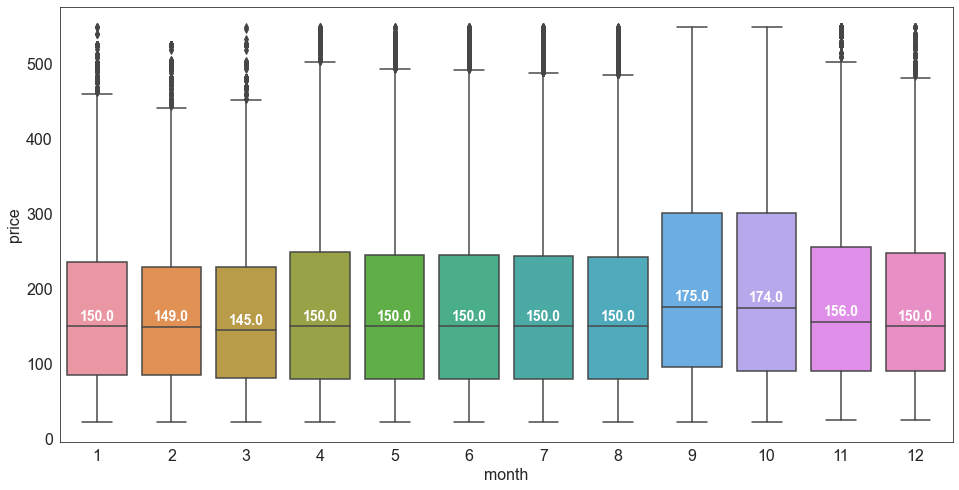

In [22]:
### Visualize
# make the box plot of listing price of each month
# apparently Sep and Oct has the highest median lisiting price of the year
m_median = calendar_new.groupby('month')['price'].median()

matplotlib.rcParams.update({'font.size': 16})

from matplotlib.pyplot import figure


sns.set_style("white")
figure(figsize=(16,8))
box_plot = sns.boxplot(data=calendar_new, x='month', y='price')

vertical_offset = m_median * 0.05

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, m_median[xtick+1] + vertical_offset[xtick+1], m_median[xtick+1], 
                  horizontalalignment='center',size='x-small',color='w',weight='semibold', fontsize =14)

plt.show()

Apparently Sep and Oct has the highest median listing price while other months are close to each other. We need to check what is the reason for this. One possible reason is that the supply in Sep and Oct is limited, so we want to check what is the listing numbers of each month

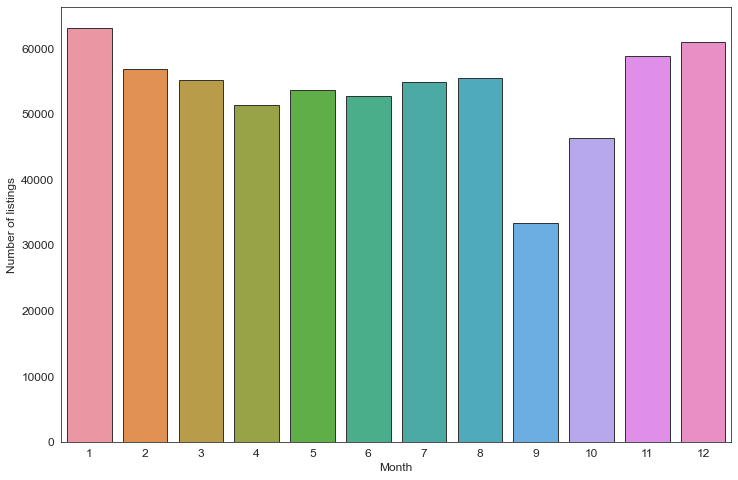

In [28]:
# check the number of listings of each month.
# clearly Sep and Oct has the least amount of listings.
# the shortage of supply or high demand might be the reason driving up the price

m_count = calendar.groupby('month')['listing_id'].count()
plt.figure(figsize = (12,8))
#sns.color_palette("rocket", as_cmap=True)
sns.barplot(x = m_count.index, y = m_count, edgecolor ='.2')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Number of listings', fontsize = 12)
plt.show()

### Q3 Conclusion

The listing price at Boston has a strong seasonality that Sep and Oct shows the highest listing price comparing to other months. This is most likely be driven by the supply shortage on Sep and Oct. Since Boston is a colleage town to a great extend, and Sep and Oct are the begining of Fall semester, so the demand of housings in Boston is also very high. This also contribute to the high price of Sep and Oct